In [1]:
import numpy as np
import pandas as pd
import scipy
import psycopg2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
from collections import Counter

In [2]:
def parse_testdata(path='../data/rainfall-submissions.tsv'):
    file = open(path,'r')
    raw = file.readlines()
    file.close()
    res = dict()
    exid = "3c79c115-0f5f-4d8e-b02c-b4b33155a4b3"
    get_code = lambda data: data["mooc-2017-ohjelmointi"]["osa02-Osa02_16.MarsinLampotilanKeskiarvo"]["/src/MarsinLampotilanKeskiarvo.java"]
    for line in raw:
        id = line[:len(exid)]
        body = json.loads(line[len(exid):])
        res[id] = get_code(body)
    return res

def parse_testdata_df(path='../data/rainfall-submissions.tsv'):
    file = open(path,'r')
    raw = file.readlines()
    file.close()
    ids = [None] * len(raw)
    code = [None] * len(raw)
    exid = "3c79c115-0f5f-4d8e-b02c-b4b33155a4b3"
    get_code = lambda data: data["mooc-2017-ohjelmointi"]["osa02-Osa02_16.MarsinLampotilanKeskiarvo"]["/src/MarsinLampotilanKeskiarvo.java"]
    for i, line in enumerate(raw):
        id = line[:len(exid)]
        body = json.loads(line[len(exid):])
        ids[i] = id
        code[i] = get_code(body)
    return pd.DataFrame({ "ids": ids, "code": code })

rain = parse_testdata()
rain_df = parse_testdata_df()

In [3]:
print(rain['b4df7baf-1ba2-4a67-8b82-dabc5a1a0bb8'])


import java.util.Scanner;

public class MarsinLampotilanKeskiarvo {

    public static void main(String[] args) {
        Scanner lukija = new Scanner(System.in);
        
        int summa = 0;
        int syotteet = 0;
        
        while (true) {
            System.out.print("Syötä luku: ");
            int syote = Integer.parseInt(lukija.nextLine());
            
            if (syote == 9999) {
                break;
            } else if (syote <= 20 && syote >= -140) {
                summa += syote;
                syotteet++;
            }
        }
        
        System.out.println("Mittausten keskiarvo: " 
                            + (double) summa / syotteet );
    }
}



In [9]:
import antlr4
from antlr_local.generated.JavaLexer import JavaLexer
from antlr_local.generated.JavaParser import JavaParser
from antlr_local.generated.JavaParserListener import JavaParserListener
from antlr_local.MyListener import KeyPrinter
from antlr_local.java_tokens import interestingTokenTypes, rareTokenTypes

import pprint

from antlr4 import RuleContext

from antlr_local.java_parsers import parse_ast_complete, parse_ast_modified, parse_complete_tree, parse_modified_tokens

code = rain['b4df7baf-1ba2-4a67-8b82-dabc5a1a0bb8']

comp = parse_complete_tree(code)
mod = parse_modified_tokens(code)

In [12]:
comp.toList()

['compilationUnit',
 'importDeclaration',
 'IMPORT',
 'qualifiedName',
 'IDENTIFIER',
 'DOT',
 'IDENTIFIER',
 'DOT',
 'IDENTIFIER',
 'SEMI',
 'typeDeclaration',
 'classOrInterfaceModifier',
 'PUBLIC',
 'classDeclaration',
 'CLASS',
 'IDENTIFIER',
 'classBody',
 'LBRACE',
 'classBodyDeclaration',
 'modifier',
 'classOrInterfaceModifier',
 'PUBLIC',
 'modifier',
 'classOrInterfaceModifier',
 'STATIC',
 'memberDeclaration',
 'methodDeclaration',
 'typeTypeOrVoid',
 'VOID',
 'IDENTIFIER',
 'formalParameters',
 'LPAREN',
 'formalParameterList',
 'formalParameter',
 'typeType',
 'classOrInterfaceType',
 'IDENTIFIER',
 'LBRACK',
 'RBRACK',
 'variableDeclaratorId',
 'IDENTIFIER',
 'RPAREN',
 'methodBody',
 'block',
 'LBRACE',
 'blockStatement',
 'localVariableDeclaration',
 'typeType',
 'classOrInterfaceType',
 'IDENTIFIER',
 'variableDeclarators',
 'variableDeclarator',
 'variableDeclaratorId',
 'IDENTIFIER',
 'ASSIGN',
 'variableInitializer',
 'expression',
 'NEW',
 'creator',
 'createdName'

In [11]:
mod

'IMPORT  \nCLASS{  \nVOID    \nMETHOD{ \nVARDEF \nASSIGN  \nNEWCLASS\nVARDEF \nASSIGN  \nVARDEF \nASSIGN  \nLOOP{ \nAPPLY   \nVARDEF \nASSIGN  \nAPPLY   \nAPPLY   \nIF{     \nASSIGN  \nBREAK   \nIF{     \nASSIGN  \nASSIGN  \nASSIGN  \n}IF     \n}IF     \n}LOOP \nAPPLY   \n}METHOD \n}CLASS  \n'

In [169]:
import requests

SOLR_URL="http://localhost:8983"
CORE="submission-search"

def add_dynamic_field(fieldName, fieldType="pint"):
    url = f'{SOLR_URL}/solr/{CORE}/schema?commit=true'
    data = {
        "add-dynamic-field": {
            "stored": "true",
            "indexed": "true",
            "name": f'*_{fieldName}',
            "type": fieldType
        }
    }
    headers = {
        "Content-type": "application/json"
    }
    res = requests.post(url, json=data, headers=headers)
    print(res.text)
    return res

def update_submission(res):
    url = f'{SOLR_URL}/solr/{CORE}/update?overwrite=true&commit=true'
    def create_solr_updation(d, subId):
        r = { f'{key}_metric': { "set": d[key] } for key in d.keys() }
        r['id'] = subId
        return r
    data = [create_solr_updation(res[sub_id], sub_id) for sub_id in res.keys()]
    headers = {
        "Content-type": "application/json"
    }
    #return data
    resp = requests.post(url, json=data, headers=headers)
    print(resp.text)
    return resp
    #http://localhost:8983/solr/submission-search/update?_=1594129245796&commitWithin=1000&overwrite=true&wt=json

#add_dynamic_field('metric')
resp = update_submission(res)

{
  "responseHeader":{
    "status":0,
    "QTime":716}}



In [167]:
resp

[{'24176cce-0737-44f7-a120-4965b0bf4b9f': {'NCSS_file_metric': {'set': 17},
   'CDAC_metric': {'set': 1},
   'CFOC_metric': {'set': 1},
   'NCSS_class_metric': {'set': 16},
   'CYC_metric': {'set': 5},
   'NCSS_method_metric': {'set': 15},
   'NPath_metric': {'set': 7},
   'bool_expression_metric': {'set': 1},
   'LOC_metric': {'set': 31}}},
 {'774992ef-83b5-45f9-8757-ffdbeecc521d': {'NCSS_file_metric': {'set': 22},
   'CDAC_metric': {'set': 1},
   'CFOC_metric': {'set': 1},
   'NCSS_class_metric': {'set': 21},
   'CYC_metric': {'set': 5},
   'NCSS_method_metric': {'set': 20},
   'NPath_metric': {'set': 5},
   'LOC_metric': {'set': 30}}},
 {'e2d744c7-f389-46a8-b44a-b2bc6af5bf2c': {'NCSS_file_metric': {'set': 16},
   'CDAC_metric': {'set': 1},
   'CFOC_metric': {'set': 1},
   'NCSS_class_metric': {'set': 15},
   'CYC_metric': {'set': 5},
   'NCSS_method_metric': {'set': 14},
   'NPath_metric': {'set': 7},
   'bool_expression_metric': {'set': 1},
   'LOC_metric': {'set': 26}}},
 {'63a5b7

In [159]:
d = res['774992ef-83b5-45f9-8757-ffdbeecc521d']
keys = d.keys()
{ key: { "set": d[key] } for key in d.keys() }

{'NCSS_file': {'set': 22},
 'CDAC': {'set': 1},
 'CFOC': {'set': 1},
 'NCSS_class': {'set': 21},
 'CYC': {'set': 5},
 'NCSS_method': {'set': 20},
 'NPath': {'set': 5},
 'LOC': {'set': 30}}

In [38]:
import psycopg2
from dotenv import load_dotenv

import os
import json

load_dotenv()

POSTGRES_HOST = os.getenv("DB_HOST")
POSTGRES_PORT = os.getenv("DB_PORT")
POSTGRES_DB = os.getenv("DB_NAME")
POSTGRES_USER = os.getenv("DB_USER")
POSTGRES_PASSWORD = os.getenv("DB_PASSWORD")

conn = psycopg2.connect(host=POSTGRES_HOST, port=POSTGRES_PORT, database=POSTGRES_DB, user=POSTGRES_USER, password=POSTGRES_PASSWORD)

cur = conn.cursor()

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def query_many(query):
    cur.execute(query)
    return cur.fetchall()

def fetch_submissions(courseId, exerciseId):
    ex_rows = query_many(f"""
    SELECT program_language FROM exercise WHERE course_id = {courseId} AND exercise_id = {exerciseId}
    """)
    rows = query_many(f"""
    SELECT submission_id, code FROM submission
    WHERE course_id = {courseId} AND exercise_id = {exerciseId}
    """)
    submissionIds = [r[0] for r in rows]
    codeList = [r[1] for r in rows]
    language = ex_rows[0][0]

    return submissionIds, codeList, language


In [147]:
import time
import subprocess
from subprocess import PIPE
import sys

METRICS_FOLDER_PATH="/tmp/codeclusters-run-metrics"
USED_CHECKSTYLE_METRICS=[
    'JavaNCSS',
    'CyclomaticComplexity',
    'NPathComplexity',
    'ClassDataAbstractionCoupling',
    'ClassFanOutComplexity',
    'BooleanExpressionComplexity'
]
CHECKSTYLE_JAR_PATH="/Users/teemu/Downloads/checkstyle-8.34-all.jar"
CHECKSTYLE_XML_PATH="/Users/teemu/Downloads/mdsol-checkstyle.xml"

def get_file_extension(language):
    if language == 'Java':
        return 'java'
    return ''

def get_metric(line):
    TYPE_MARKER = 'type:'
    VAL_MARKER = 'val:'
    def get(line, marker):
        marker_idx = line.find(marker)
        return line[(marker_idx + len(marker)):(line.find(' ', marker_idx))]
    mtype = get(line, TYPE_MARKER)
    val = get(line, VAL_MARKER)
    return mtype, int(val)

def create_folder(runId):
    dir_path = f"{METRICS_FOLDER_PATH}/{runId}"
    try:
        os.makedirs(dir_path)    
        print("Directory " , dir_path, " created ")
        return dir_path
    except FileExistsError:
        print("Directory " , dir_path, " already exists") 
        return dir_path

def write_files(submissionIds, codeList, fileExt, folderPath):
    for idx, code in enumerate(codeList):
        with open(f"{folderPath}/{submissionIds[idx]}.{fileExt}", "w") as f:
            f.write(code)

def delete_folder(folderPath):
    files = os.listdir(folderPath)
    for file in files:
        os.remove(f'{folderPath}/{file}')
    os.rmdir(folderPath)

def add_loc(res, submissionIds, codeList):
    locs = [len(code.split('\n')) for code in codeList]
    for idx, sub_id in enumerate(submissionIds):
        res[sub_id]['LOC'] = locs[idx]
    return res

def run_checkstyle(folderPath):
    jar_path = "/Users/teemu/Downloads/checkstyle-8.34-all.jar"
    xml_path = "/Users/teemu/Downloads/mdsol-checkstyle.xml"
    args = ['java', '-jar', CHECKSTYLE_JAR_PATH, '-c', CHECKSTYLE_XML_PATH, 'com.puppycrawl.tools.checkstyle.gui.Main', f'{folderPath}/']

    checkstyle_result = subprocess.run(args, stdout=PIPE, stderr=PIPE, check=False)
    decoded = checkstyle_result.stdout.decode(sys.stdout.encoding) + checkstyle_result.stderr.decode(sys.stderr.encoding)
    return decoded.split('\n')

def generate_result_dict(lines, submissionIds):
    res = {}
    for line in lines:
        sub_id = line.split('/')[-1][:36]
        module = line.split(' ')[-1][1:-1]
        if sub_id not in res and sub_id in submissionIds:
            res[sub_id] = {}
        if module in USED_CHECKSTYLE_METRICS:
            m, v = get_metric(line)
            res[sub_id][m] = v
    return res

def fetch_and_run_metrics(courseId, exerciseId):
    submissionIds, codeList, language = fetch_submissions(courseId, exerciseId)
    file_ext = get_file_extension(language)
    run_id = int(time.time())
    folderPath = ''
    lines = []
    res = {}
    try:
        folderPath = create_folder(run_id)
        write_files(submissionIds, codeList, file_ext, folderPath)
        lines = run_checkstyle(folderPath)
        res = generate_result_dict(lines, submissionIds)
        res = add_loc(res, submissionIds, codeList)
        delete_folder(folderPath)
    except:
        delete_folder(folderPath)
        raise
    return lines, res

lines, res = fetch_and_run_metrics(2, 4)

Directory  /tmp/codeclusters-run-metrics/1594129064  created 


In [148]:
res

{'24176cce-0737-44f7-a120-4965b0bf4b9f': {'NCSS_file': 17,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 16,
  'CYC': 5,
  'NCSS_method': 15,
  'NPath': 7,
  'bool_expression': 1,
  'LOC': 31},
 '774992ef-83b5-45f9-8757-ffdbeecc521d': {'NCSS_file': 22,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 21,
  'CYC': 5,
  'NCSS_method': 20,
  'NPath': 5,
  'LOC': 30},
 'e2d744c7-f389-46a8-b44a-b2bc6af5bf2c': {'NCSS_file': 16,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 15,
  'CYC': 5,
  'NCSS_method': 14,
  'NPath': 7,
  'bool_expression': 1,
  'LOC': 26},
 '63a5b7fe-266f-495f-9a31-fed29462be42': {'NCSS_file': 16,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 15,
  'CYC': 5,
  'NCSS_method': 14,
  'NPath': 7,
  'bool_expression': 1,
  'LOC': 30},
 '343694cc-a881-42c5-9cb0-838db0e9447b': {'NCSS_file': 18,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 17,
  'CYC': 5,
  'NCSS_method': 16,
  'NPath': 5,
  'bool_expression': 1,
  'LOC': 33},
 '24d4ce9e-bdef-4ac6-9891-1c3540ff29fb': {'NCSS_file': 14,
  'CDAC': 1,
  

(array([ 1.,  6., 30., 70.,  0.,  1.,  0.,  0.,  0.,  2.]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <a list of 10 Patch objects>)

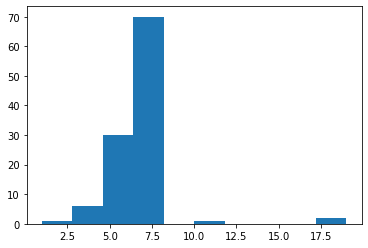

In [149]:
plt.hist([res[x]['NPath'] for x in res], bins=10)

In [130]:
[res[x] for x in res]

[{'NCSS_file': 17,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 16,
  'CYC': 5,
  'NCSS_method': 15,
  'NPath': 7,
  'bool_expression': 1},
 {'NCSS_file': 22,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 21,
  'CYC': 5,
  'NCSS_method': 20,
  'NPath': 5},
 {'NCSS_file': 16,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 15,
  'CYC': 5,
  'NCSS_method': 14,
  'NPath': 7,
  'bool_expression': 1},
 {'NCSS_file': 16,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 15,
  'CYC': 5,
  'NCSS_method': 14,
  'NPath': 7,
  'bool_expression': 1},
 {'NCSS_file': 18,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 17,
  'CYC': 5,
  'NCSS_method': 16,
  'NPath': 5,
  'bool_expression': 1},
 {'NCSS_file': 14,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 13,
  'CYC': 4,
  'NCSS_method': 12,
  'NPath': 4,
  'bool_expression': 1},
 {'NCSS_file': 19,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 18,
  'CYC': 5,
  'NCSS_method': 17,
  'NPath': 7,
  'bool_expression': 1},
 {'NCSS_file': 21,
  'CDAC': 1,
  'CFOC': 1,
  'NCSS_class': 20,


In [88]:
res[2][95:(95+14)]

'type:NCSS_file'

In [87]:
res[2][95:].find(',')

14

In [81]:
lines[2]

'[WARN] /tmp/codeclusters-run-metrics/1594114943/24176cce-0737-44f7-a120-4965b0bf4b9f.java:2:1: Puuttuu paketti ilmoitus. [PackageDeclaration]'

In [74]:
lines

['Aloitetaan tarkistus...',
 '[INFO] /tmp/codeclusters-run-metrics/1594114943/24176cce-0737-44f7-a120-4965b0bf4b9f.java:2:1: NCSS file: [17] [JavaNCSS]',
 '[WARN] /tmp/codeclusters-run-metrics/1594114943/24176cce-0737-44f7-a120-4965b0bf4b9f.java:2:1: Puuttuu paketti ilmoitus. [PackageDeclaration]',
 '[INFO] /tmp/codeclusters-run-metrics/1594114943/24176cce-0737-44f7-a120-4965b0bf4b9f.java:4:1: Class Data Abstraction Coupling is 1 (max recommended is 0) classes [Scanner]. [ClassDataAbstractionCoupling]',
 '[INFO] /tmp/codeclusters-run-metrics/1594114943/24176cce-0737-44f7-a120-4965b0bf4b9f.java:4:1: Class Fan-Out Complexity is 1 (max recommended is 0). [ClassFanOutComplexity]',
 '[WARN] /tmp/codeclusters-run-metrics/1594114943/24176cce-0737-44f7-a120-4965b0bf4b9f.java:4:1: Hyödyllisyys luokat ei pitäisi olla julkinen tai oletus rakentaja. [HideUtilityClassConstructor]',
 '[WARN] /tmp/codeclusters-run-metrics/1594114943/24176cce-0737-44f7-a120-4965b0bf4b9f.java:4:1: Luokka olisi määritel

In [78]:
lines[4].split('/')[-1][53:]

'Fan-Out Complexity is 1 (max recommended is 0). [ClassFanOutComplexity]'

In [71]:
len('24176cce-0737-44f7-a120-4965b0bf4b9f')

36